# Unsuprvised image classification

## K-means clustering

K-means clustering is a method of vector quantization that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. The algorithm will consider each image as vector and identify clusters of images sharing common traits. 

In [62]:
import os
import re
import numpy as np

from PIL import Image 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, accuracy_score

In [63]:
data_folder = "../unsupervised_image_classification/data" # the path to the image folder

The function below will preprocess the images in the data folder to provide a features array on which the k-mean will be fitted and labels vector which will be used to compare the k-means performance. 

In [64]:
def prep_data(folder):
    '''
    The function will open every image in the given folder,
    apply a preprocessing methods and return a feartures array, 
    along with a labels vector and the image categories inferred
    from image titles.
    input: folder path
    output: image classnames, labels vector, features array
    '''
    labels = []
    features =[]
    newsize = (300, 300) # the final image size
    labelencoder = LabelEncoder()
    for root, folders, filenames in os.walk(folder):
        for file in filenames:
            # infer the labels from the image title
            labels.append(re.findall(r"^([^.]+)", file)) 
            # load and preprocess the image file
            imgFile = os.path.join(root,file)
            img = Image.open(imgFile)
            # resize the image by keeping the aspect ratio
            img_resize = img.resize(newsize, Image.ANTIALIAS)
            img_resize = np.array(img_resize)
            features.append(img_resize.ravel())
    # output the class names
    classnames = list(np.unique(labels))
    # output the individual labels
    labels = labelencoder.fit_transform(np.array(labels).ravel())
    # output a features matrix of all images
    features = np.array(features)/255.
    return classnames, labels, features

In [65]:
classnames, labels, features = prep_data(data_folder)

MemoryError: Unable to allocate 4.03 GiB for an array with shape (2002, 270000) and data type float64

In [ ]:
print(len(features), 'features with shape:', features.shape)
print(len(labels), 'labels with shape:', labels.shape)
print(len(classnames), 'classes:', classnames)

Set the number of clusters to the number of uniques labels in the dataset.

In [ ]:
n_clusters = len(np.unique(labels))

Fit the k-means algorithm to the preprocessed features and retrieve the cluster labels.

In [11]:
kmeans = MiniBatchKMeans(n_clusters = n_clusters, n_init=20).fit(features)

Check the baseline accuracy score and the performance of the k-means algorithm on the provided dataset.

We will use the Normalized Mutual Information (NMI) score to evaluate our model. Mutual information is a symmetric measure for the degree of dependency between the clustering and the manual classification. It is based on the notion of cluster purity pi, which measures the quality of a single cluster Ci, the largest number of objects in cluster Ci which Ci has in common with a manual class Mj, having compared Ci to all manual classes in M. Because NMI is normalized, we can use it to compare clusterings with different numbers of clusters. The closer the NMI value is to 1 the more accurate the cluster partition.

In [53]:
normalized_mutual_info_score(labels, kmeans.labels_)

0.0017355660776335706

In [21]:
def plot_conf_mat(labels_true, labels_pred):
    '''
    The function will plot the confusion matrix
    for the true and the predicted labels.
    input: the original labels, predicted labels
    output: confusion matrix plot
    '''
    sns.set(font_scale=3)
    plt.figure(figsize=(10, 5))
    sns.heatmap(confusion_matrix(labels_true, labels_pred), annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=30)
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Clustering label', fontsize=25)
    plt.show()

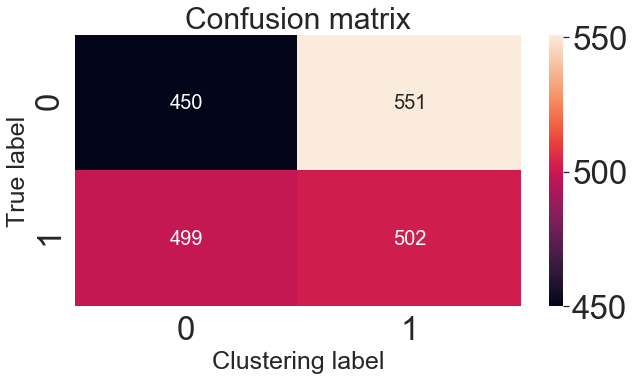

In [22]:
plot_conf_mat(labels, kmeans.labels_)

The k-means algorithm does not perform better than a random labeling of the raw images of the dataset. More can be said after retrieving the cluster names using the function below.

In [30]:
def retrieve_info(cluster_labels,labels,classnames):
    '''
    Associates most probable label with each cluster in k-means model.
    input: predicted cluster labels, the original labels, the class names
    output: dictionary of clusters assigned to each label
    '''
    reference_labels = {}
    # for loop to run through each label of cluster label
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(labels[index==1]).argmax()
        reference_labels[i] = classnames[num]
    return reference_labels

In [31]:
retrieve_info(kmeans.labels_, labels, classnames)

{0: 'dog', 1: 'cat'}

499 dog pictures are indentified as such which is less than 502 pictures of dogs identified as cats. The performance on cats photos is slightly better as 551 cat pjotos are identified as such and 450 photos are identified as of dogs.

A twist to the classification can be a different preprocessing using transfer learning to extract the high-level features.

## Transfert learning applied to K-means clustering

Transfer learning using a pretrained ResNet50 will first extract the high-level feature vector which will be then fitted by k-means to perform the clustering. 

In [51]:
import os
import cv2
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score

import keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

Download the pretrained ResNet50 and freeze its weights. 

In [40]:
transf_model = Sequential()
transf_model.add(ResNet50(weights='imagenet', include_top=False))

# say no to training first layer (ResNet) model. It is already trained
transf_model.layers[0].trainable = False

In [41]:
def extract_vector(folder):
    '''
    The function will open every image in the given folder,
    apply a preprocessing methods and return a feartures array, 
    along with a labels vector and the image categories inferred
    from image titles.
    input: folder path
    output: image classnames, labels vector, features array
    '''
    resnet_feature_list = []
    labels = []
    labelencoder = LabelEncoder()
    counter = 0
    for root, dirs, filenames in os.walk(folder):
        for file in filenames:
            # infer the labels from the image title
            labels.append(re.findall(r"^([^.]+)", file))
            # load and preprocess the image file
            imgFile = os.path.join(root,file)
            img = cv2.imread(imgFile)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_large = cv2.resize(img,(224,224))
            img_model = preprocess_input(np.expand_dims(img_large.copy(), axis=0))
            # for every image apply the ResNet50 to create a feature vector 
            resnet_feature = transf_model.predict(img_model)
            resnet_feature_np = np.array(resnet_feature)
            resnet_feature_list.append(resnet_feature_np.flatten())
            # keep track of processed images via a counter
            counter+=1
            if counter%100==0:
                print(f'{counter} images processed')
    # output a features matrix of all images
    features_array = np.array(resnet_feature_list)
    # output the class names
    classnames = list(np.unique(labels))
    # output the individual labels
    labels = labelencoder.fit_transform(np.array(labels).ravel())
    return classnames, labels, features_array

In [42]:
classnames, labels, features_array = extract_vector(data_folder)

100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
1200 images processed
1300 images processed
1400 images processed
1500 images processed
1600 images processed
1700 images processed
1800 images processed
1900 images processed
2000 images processed


In [44]:
print(len(features), 'features with shape:', features_array.shape)
print(len(labels), 'labels with shape:', labels.shape)
print(len(classnames), 'classes:', classnames)

2002 features with shape: (2002, 100352)
2002 labels with shape: (2002,)
2 classes: ['cat', 'dog']


Fit the k-means algorithm to the preprocessed features and retrieve the cluster labels.

In [45]:
kmeans_t = MiniBatchKMeans(n_clusters = n_clusters, n_init=20).fit(features_array)

Notice the improvement in the NMI score. A preprocesing using transfer learning to infer high-level features form images increased the NMI from 0.0017 to 0.8083. A significant improvement is shown by the confusion matrix. Only a total of 67 images have been misclassified. Cat are more prone to be confused for dogs than the opposite. 

In [52]:
normalized_mutual_info_score(labels, kmeans_t.labels_)

0.808372009487411

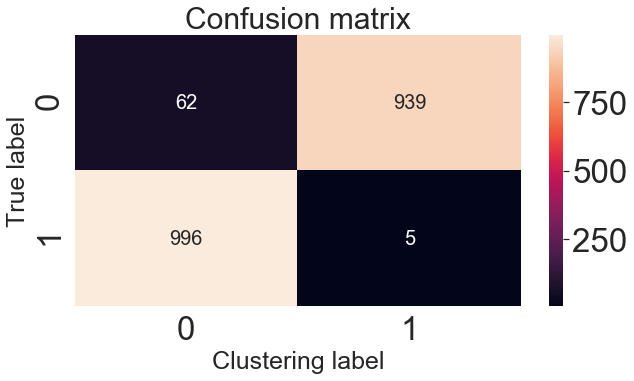

In [49]:
plot_conf_mat(labels, kmeans_t.labels_)

In [55]:
retrieve_info(kmeans_t.labels_,labels, classnames)

{0: 'dog', 1: 'cat'}